In [3]:
import numpy as np
import csv
import igl
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import geopandas as gpd
from shapely.ops import triangulate
import meshio
import os


In [2]:
current_dir = os.getcwd()
path = os.path.join(current_dir, "points_oceans.npy")

data = np.load(path)
print(data.shape)

# Plotting the points
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(data[:,0], -data[:,1], s=1, c='b', marker='o')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\muhan\\Documents\\Datalogi\\bachelor\\Bachelor-project\\Code\\points_oceans.npy'

In [ ]:
data = np.load(path)

# Filtering the egdes
filtered_data = data[(data[:,0] < 3.141) & (data[:,0] > -3.141) & (data[:,1] > 8.8817*10**(-16))]
filtered_data = filtered_data[::10] # Taking every 10th point
print(filtered_data.shape)
# Plotting the points
# filtered_data = filtered_data[0:400000,]
px.scatter(x=filtered_data[:,0], y=-filtered_data[:,1])

In [ ]:
current_dir = os.getcwd()
path2 = os.path.join(current_dir, "cartesian_coords_points_oceans.npz")

data2 = np.load(path2)
x = data2['arr_0']
y = data2['arr_1']

print(x.shape)
print(y.shape)

In [4]:
#Projecting the point on the mesh
def project_point_to_mesh(point, vecs):
    u = vecs[1] - vecs[0]
    v = vecs[2] - vecs[0]
    
    n = np.cross(u, v)
    w = point - vecs[0]

    gamma = np.dot(np.cross(u, w), n) / np.dot(n, n)
    beta = np.dot(np.cross(w, v), n) / np.dot(n, n)
    alpha = 1 - gamma - beta

    y = alpha * vecs[0] + beta * vecs[1] + gamma * vecs[2]
    return y

#Projecting the point on the mesh
def project_point_to_mesh2(point, vecs):
    u = vecs[1] - vecs[0]
    v = vecs[2] - vecs[0]
    n = np.cross(u, v)
    w = point - vecs[0]

    gamma = np.dot(np.cross(u, w), n) / np.dot(n, n)
    beta = np.dot(np.cross(w, v), n) / np.dot(n, n)
    alpha = 1 - gamma - beta

    # y = alpha * vecs[0] + beta * vecs[1] + gamma * vecs[2]
    y = (1 - gamma) * vecs[0] + (gamma * (1 - beta)) * vecs[1] + (gamma * beta) * vecs[2]
    return y
    # if alpha >= 0 and beta >= 0 and gamma >= 0 and alpha <= 1 and beta <= 1 and gamma <= 1:
    #     return alpha * vecs[0] + beta * vecs[1] + gamma * vecs[2]
    # else:
    #     return (1 - u) * a + (u * (1 - v)) * b + (u * v) * c

In [5]:
import numpy as np

def project_to_triangle(point, triangle_vertices):
    v0, v1, v2 = triangle_vertices

    # Compute the vectors representing the edges of the triangle
    e0 = v1 - v0
    e1 = v2 - v0

    # Calculate the barycentric coordinates of the projection point
    e0_dot_e0 = np.dot(e0, e0)
    e0_dot_e1 = np.dot(e0, e1)
    e1_dot_e1 = np.dot(e1, e1)
    e0_dot_point = np.dot(e0, point - v0)
    e1_dot_point = np.dot(e1, point - v0)

    denom = e0_dot_e0 * e1_dot_e1 - e0_dot_e1 * e0_dot_e1

    barycentric_coords = np.empty(3)
    barycentric_coords[0] = (e1_dot_e1 * e0_dot_point - e0_dot_e1 * e1_dot_point) / denom
    barycentric_coords[1] = (e0_dot_e0 * e1_dot_point - e0_dot_e1 * e0_dot_point) / denom
    barycentric_coords[2] = 1.0 - barycentric_coords[0] - barycentric_coords[1]

    # Determine if the projection point is inside the triangle
    if np.all(barycentric_coords >= 0) and np.all(barycentric_coords <= 1):
        # Calculate the projected point by interpolating the vertices
        projected_point = barycentric_coords[0] * v0 + barycentric_coords[1] * v1 + barycentric_coords[2] * v2
        return projected_point

    return None  # Return None if the point is outside the triangle


[0.25 0.25 0.  ]
[ 1.125 -0.5    0.   ]


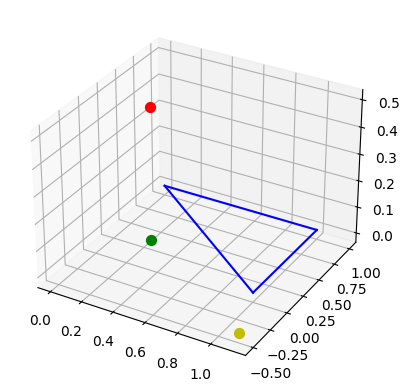

In [21]:
#test projec_point_to_mesh
vecs = np.array([[1,0,0],[0,1,0],[1,1,0]])
point = np.array([0.25, 0.25, 0.5])

pp1 = project_point_to_mesh(point, vecs)
print(pp1)
pp2 = project_point_to_mesh2(point, vecs)
print(pp2)

x = [vec[0] for vec in vecs]
y = [vec[1] for vec in vecs]
z = [vec[2] for vec in vecs]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the triangle
ax.plot([x[0], x[1]], [y[0], y[1]], [z[0], z[1]], 'b-')
ax.plot([x[1], x[2]], [y[1], y[2]], [z[1], z[2]], 'b-')
ax.plot([x[2], x[0]], [y[2], y[0]], [z[2], z[0]], 'b-')

ax.scatter(point[0], point[1], point[2], color='r', s=50)
ax.scatter(pp1[0], pp1[1], pp1[2], color='g', s=50)
ax.scatter(pp2[0], pp2[1], pp2[2], color='y', s=50)

# Show the plot
plt.show()

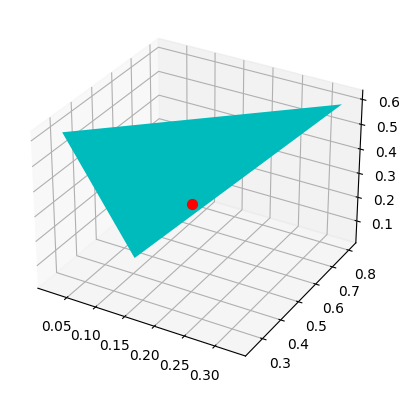

In [9]:
# generate a triangle in 3d with random coordinates
triangle = np.random.rand(3, 3)
point = np.array([0.25, 0.25, 0.5])

# project the point on the triangle plane
projected_point2 = project_point_to_mesh2(point, triangle)
projected_point = project_point_to_mesh(point, triangle)

# plot the triangle plane
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(triangle[:, 0], triangle[:, 1], triangle[:, 2], color = "cyan" ,linewidth=0.2 ,antialiased=True)
ax.scatter(point[0], point[1], point[2], color='r', s=50)
ax.scatter(projected_point[0], projected_point[1], projected_point[2], color='g', s=50)
ax.scatter(projected_point2[0], projected_point2[1], projected_point2[2], color='y', s=50)
plt.show()

In [20]:
# plot the triangle plane and the projected point in plotly

# generate a triangle in 3d with random coordinates
triangle = np.random.rand(3, 3)
point = np.array([0.25, 0.25, 0.5])

# project the point on the triangle plane
pp = project_point_to_mesh(point, triangle)
pp2 = project_point_to_mesh2(point, triangle)
ppp = project_point_to_mesh(pp, triangle)

# plot the triangle plane
fig = go.Figure(data=[go.Mesh3d(x=triangle[:, 0], y=triangle[:, 1], z=triangle[:, 2], color='cyan', opacity=0.50)])
fig.add_trace(go.Scatter3d(x=[point[0]], y=[point[1]], z=[point[2]], mode='markers', name = "Original", marker=dict(color='red', size=10)))
fig.add_trace(go.Scatter3d(x=[pp[0]], y=[pp[1]], z=[pp[2]], mode='markers', name = "Projection 1", marker=dict(color='green', size=10)))
fig.add_trace(go.Scatter3d(x=[pp2[0]], y=[pp2[1]], z=[pp2[2]], mode='markers', name = "Projection 2", marker=dict(color='yellow', size=10)))
fig.show()
